In [9]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt


In [1]:
# Load the stock price data to start with EDA
data = pd.read_csv(r'stock_price.csv')

# Display the first few rows to understand the structure of the data
data.head()


,日付け,終値,始値,高値,安値,出来高,変化率 %
0,2024-08-01,156.3,159.3,159.4,156.1,79.15M,-2.56%
1,2024-07-31,160.4,158.2,160.7,158.1,173.91M,1.07%
2,2024-07-30,158.7,158.8,159.2,158.0,138.14M,-0.63%
3,2024-07-29,159.7,158.7,160.2,158.4,126.28M,1.14%
4,2024-07-26,157.9,159.3,159.6,157.9,155.08M,-0.13%


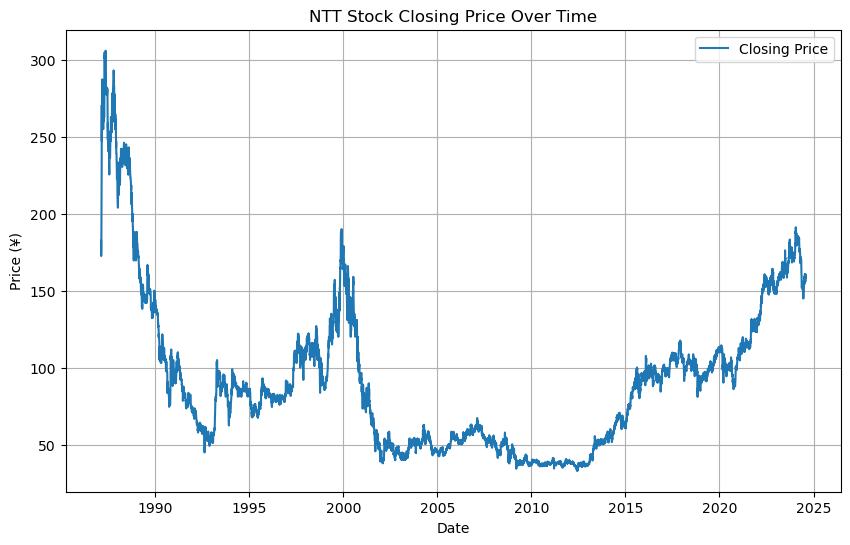

In [11]:

# Plotting the stock closing price over time
plt.figure(figsize=(10, 6))
plt.plot(data['日付け'], data['終値'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (¥)')
plt.title('NTT Stock Closing Price Over Time')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\kil\AppData\Local\Temp\ipykernel_7240\1585119577.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data[['終値', '始値', '高値', '安値', '出来高']].corr()


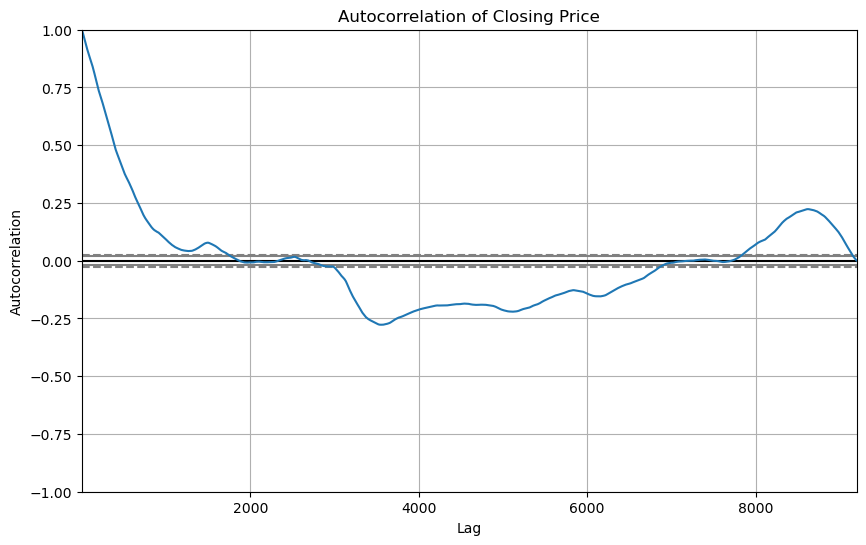

(                終値           始値           高値           安値
 count  9202.000000  9202.000000  9202.000000  9202.000000
 mean     92.180961    92.256183    93.176451    91.330146
 std      50.452228    50.598215    51.049837    50.087405
 min      33.000000    33.000000    33.200000    32.200000
 25%      52.000000    52.100000    52.800000    51.500000
 50%      85.100000    85.100000    86.050000    84.200000
 75%     110.800000   110.800000   111.900000   109.275000
 max     305.900000   309.800000   311.800000   303.900000,
           終値        始値        高値        安値
 終値  1.000000  0.999547  0.999795  0.999754
 始値  0.999547  1.000000  0.999755  0.999791
 高値  0.999795  0.999755  1.000000  0.999660
 安値  0.999754  0.999791  0.999660  1.000000,
 (-1.641895059527463,
  0.4612707414699144,
  29,
  9172,
  {'1%': -3.4310631630047332,
   '5%': -2.8618551724921812,
   '10%': -2.5669377612579782},
  38327.22635819262))

In [10]:
# Display general statistics
general_stats = data.describe()

# Correlation matrix to understand relationships between variables
correlation_matrix = data[['終値', '始値', '高値', '安値', '出来高']].corr()

# Autocorrelation for the closing price to see if past values affect future prices
from pandas.plotting import autocorrelation_plot

# ADF test for stationarity
adf_result = adfuller(data['終値'])

# Plotting autocorrelation
plt.figure(figsize=(10, 6))
autocorrelation_plot(data['終値'])
plt.title('Autocorrelation of Closing Price')
plt.grid(True)
plt.show()

# Display summary stats and correlation matrix
general_stats, correlation_matrix, adf_result


In [12]:
# To address the stationarity issue, let's apply differencing to make the series stationary
data['Price Difference'] = data['終値'].diff()

# Drop the first NaN value caused by differencing
data_diff = data.dropna()

# Checking if the data is now stationary using the ADF test
adf_result_diff = adfuller(data_diff['Price Difference'])

# Scaling the data (as done previously) for LSTM or any other model that benefits from scaled data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_diff[['終値']])

# Display the ADF result after differencing and a few rows of the scaled data
adf_result_diff, scaled_data[:5]


((-15.765887132120277,
  1.1766290673802043e-28,
  28,
  9172,
  {'1%': -3.4310631630047332,
   '5%': -2.8618551724921812,
   '10%': -2.5669377612579782},
  38324.149172472404),
 array([[0.46683767],
        [0.46060828],
        [0.46427263],
        [0.4576768 ],
        [0.45840967]]))

Epoch 1/10
229/229 [==============================] - 14s 42ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 2/10
229/229 [==============================] - 8s 37ms/step - loss: 4.8131e-04 - val_loss: 6.9346e-04
Epoch 3/10
229/229 [==============================] - 8s 37ms/step - loss: 4.0782e-04 - val_loss: 9.5840e-04
Epoch 4/10
229/229 [==============================] - 8s 36ms/step - loss: 3.8036e-04 - val_loss: 7.1601e-04
Epoch 5/10
229/229 [==============================] - 8s 36ms/step - loss: 3.4530e-04 - val_loss: 0.0014
Epoch 6/10
229/229 [==============================] - 8s 36ms/step - loss: 3.1996e-04 - val_loss: 4.9346e-04
Epoch 7/10
229/229 [==============================] - 8s 36ms/step - loss: 2.8798e-04 - val_loss: 4.1100e-04
Epoch 8/10
229/229 [==============================] - 8s 36ms/step - loss: 2.6822e-04 - val_loss: 3.8132e-04
Epoch 9/10
229/229 [==============================] - 8s 36ms/step - loss: 2.6604e-04 - val_loss: 4.2382e-04
Epoch 10/10
58/58 [===========

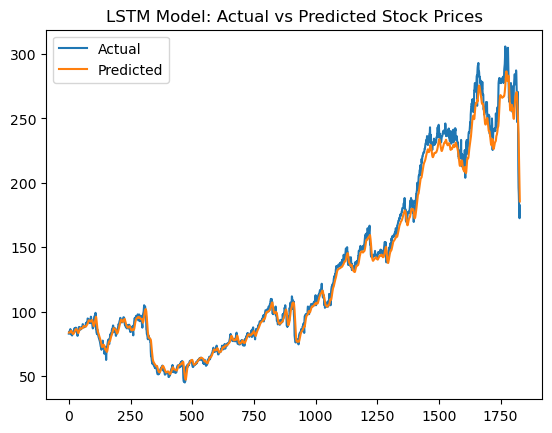

In [13]:
# Prepare data for LSTM
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Rescale to original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f'RMSE: {rmse}')

# Plotting actual vs predicted
import matplotlib.pyplot as plt
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Model: Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


Epoch 1/50
115/115 [==============================] - 23s 155ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 2/50
115/115 [==============================] - 17s 148ms/step - loss: 7.9188e-04 - val_loss: 0.0015
Epoch 3/50
115/115 [==============================] - 17s 146ms/step - loss: 7.4049e-04 - val_loss: 0.0012
Epoch 4/50
115/115 [==============================] - 17s 148ms/step - loss: 6.8765e-04 - val_loss: 0.0039
Epoch 5/50
115/115 [==============================] - 18s 156ms/step - loss: 5.8396e-04 - val_loss: 0.0024
Epoch 6/50
115/115 [==============================] - 19s 169ms/step - loss: 5.4606e-04 - val_loss: 0.0013
Epoch 7/50
115/115 [==============================] - 18s 159ms/step - loss: 4.8540e-04 - val_loss: 0.0014
Epoch 8/50
115/115 [==============================] - 20s 172ms/step - loss: 4.5698e-04 - val_loss: 9.5178e-04
Epoch 9/50
115/115 [==============================] - 19s 163ms/step - loss: 4.5320e-04 - val_loss: 0.0011
Epoch 10/50
115/115 [================

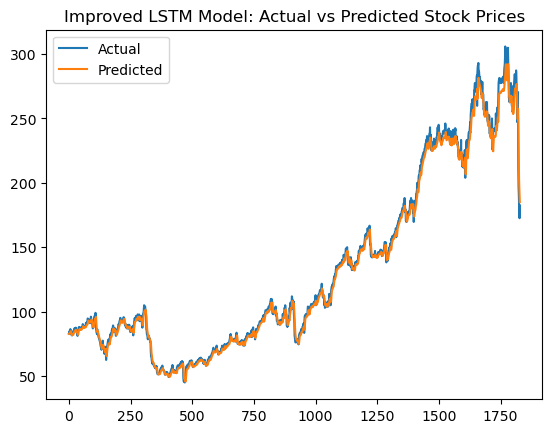

In [14]:
# Rebuild the model with more units, layers, and modified parameters
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Build the improved LSTM model with more units and layers
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the improved LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Predicting on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Rescale to original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the improved model using RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f'Improved RMSE: {rmse}')

# Plot actual vs predicted values
import matplotlib.pyplot as plt
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Improved LSTM Model: Actual vs Predicted Stock Prices')
plt.legend()
plt.show()


In [15]:
print('Model Improvement % : ', ((6.95-4.72)/6.95)*100)

Model Improvement % :  32.08633093525181


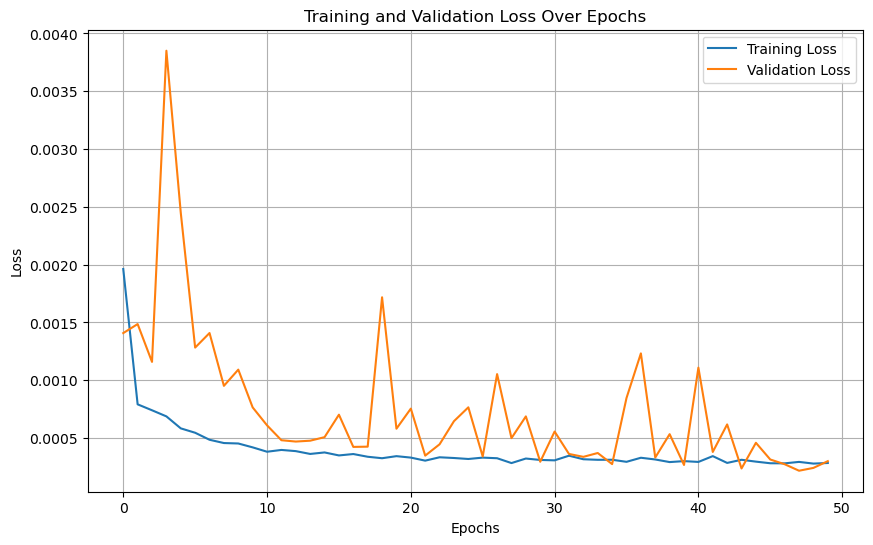

In [16]:
# Plotting the loss curve to visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

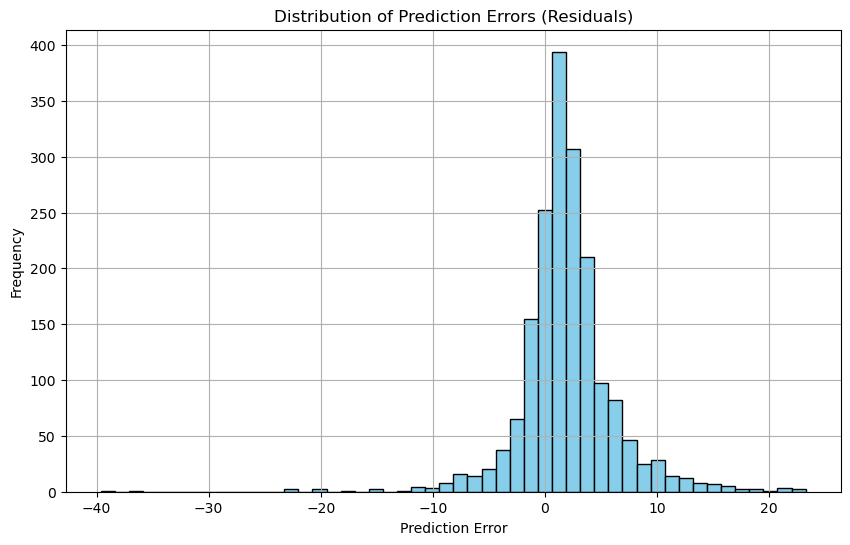

In [17]:
# Calculating residuals (differences between actual and predicted values)
residuals = y_test_rescaled - predictions

# Plotting the distribution of residuals (error distribution)
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black', color='skyblue')
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [18]:
# Overfitting check: Compare training loss and validation loss
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

if validation_loss[-1] > training_loss[-1] * 1.5:
    print("Warning: The model is likely overfitting as the validation loss is much higher than training loss.")
else:
    print("No significant overfitting detected.")


No significant overfitting detected.
